In [1]:
import numpy
import matplotlib.patches as patches
from matplotlib import colors
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from PDE2D.EIT import *
import matplotlib.patches as patches

In [2]:
def radius_fnc(radius):
    return 0.8 * radius
#radius_fnc = None

In [3]:
bbox = [[-1.05, -1.05], [1.05, 1.05]]
resolution_image = [256, 256]
spp_image = 16384
epsilon = 1e-5

res = 512
spp_boundary = 2 ** 22

radius = 1
computation_radius = 0.8

object_potential = -10
origin_object = mi.Vector2f(0.1, 0.2)
radius_object = mi.Float(0.3)

parameters = {}
parameters["freq"] = 2
parameters["bias"] = 6
parameters["scale"] = 1

def boundary_dirichlet_generator(parameters):
    def boundary_dirichlet(points):
        angle = dr.atan2(points[0], points[1])
        return parameters["scale"] * dr.sin(angle * parameters["freq"]) + parameters["bias"]
    return boundary_dirichlet


out_dirichlet = FunctionCoefficient("dirichlet", parameters, boundary_dirichlet_generator)
#out_dirichlet = ConstantCoefficient("dirichlet", 1)#object_potential * radius_object)
in_dirichlet = ConstantCoefficient("dirichlet", object_potential)

in_shape = CircleShape(origin = mi.Vector2f(origin_object), radius = radius_object, name = "in-boundary", 
                       dirichlet=in_dirichlet, epsilon=epsilon)
out_shape = CircleShape(origin = mi.Vector2f(0.0, 0.0), radius = 1.0, name = "out-boundary", 
                        dirichlet=out_dirichlet, epsilon = epsilon)

shape_holder = ShapeHolderDiscrete(out_shape=out_shape, in_shape=in_shape, epsilon=epsilon)

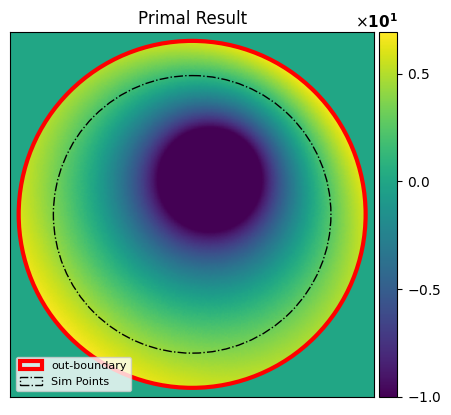

In [4]:
points, film_points = create_image_points(bbox, resolution_image, spp_image)
wos = WostDiscrete(shape_holder, radius_fnc = radius_fnc)
L = wos.solve(points_in = points)
image_0, tensor = create_image_from_result(L, film_points, resolution_image)
fig, (ax1) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image_0, ax1)
ax1.set_title("Primal Result")
shape_holder.out_boundary.sketchNeumann(ax1, bbox, resolution_image)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax1.add_patch(sphere)
ax1.legend(loc = "lower left", fontsize = 8)

In [5]:

points, film_points, normal_dir = shape_holder.out_boundary.create_boundary_points(distance=computation_radius - radius, res = res, spp = spp_boundary)
wos.clean(dr.width(points))
L = wos.solve(points_in = points)
tensor, tensor_mi = shape_holder.out_boundary.create_boundary_result(L, film_points = film_points, resolution = res)
boundary_dirichlet = shape_holder.out_boundary.create_boundary_coefficient(tensor_mi)


In [6]:
wos.clean(dr.width(points))
L = wos.solve_dir_derivative(points_in = points, derivative_dir_in = -dr.normalize(points))
tensor, tensor_mi = shape_holder.out_boundary.create_boundary_result(L, film_points = film_points, resolution = res)
boundary_neumann= shape_holder.out_boundary.create_boundary_coefficient(tensor_mi)

Text(0.5, 1.0, 'Dirichlet Cut')

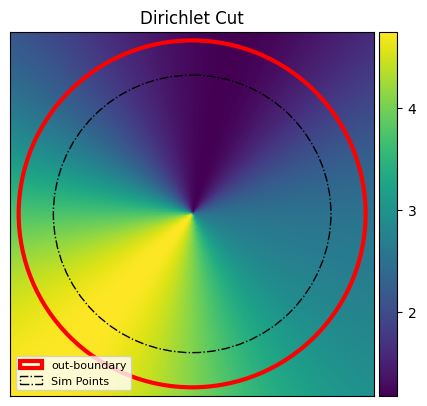

In [7]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_dirichlet.visualize(ax, bbox, resolution= resolution_image)
shape_holder.out_boundary.sketchNeumann(ax, bbox, resolution_image)
ax.legend(loc="lower left", fontsize=8)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax.add_patch(sphere)
ax.legend(loc = "lower left", fontsize = 8)
ax.set_title("Dirichlet Cut")

Text(0.5, 1.0, 'Neumann Cut')

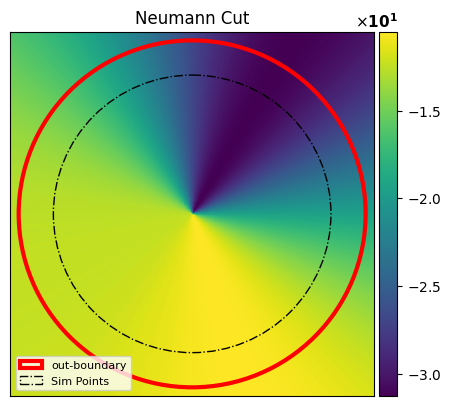

In [8]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_neumann.visualize(ax, bbox, resolution= resolution_image)
shape_holder.out_boundary.sketchNeumann(ax, bbox, resolution_image)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax.add_patch(sphere)
ax.legend(loc="lower left", fontsize=8)
ax.set_title("Neumann Cut")

In [13]:
angle_partition1 = np.array([0, 2 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map1 = np.array([True, False, True, False])

angle_partition2 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map2 = np.array([False, False, False, False])
shape1 = CircleShape(origin=mi.Vector2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition1, dirichlet_map=dirichlet_map1)
shape_holder1 = ShapeHolderDiscrete(out_shape=shape1, in_shape=in_shape, epsilon=epsilon)

shape2 = CircleShape(origin=mi.Vector2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition2, dirichlet_map=dirichlet_map2)
shape_holder2 = ShapeHolderDiscrete(out_shape=shape2, in_shape=in_shape, epsilon=epsilon)

In [14]:
bbox_ = [[-1.05 * computation_radius, -1.05 * computation_radius], [1.05 * computation_radius, 1.05 * computation_radius]]
points, film_points = create_image_points(bbox_, resolution_image, spp_image)
wos1 = WostDiscrete(shape_holder1, radius_fnc = radius_fnc)
L1 = wos1.solve(points_in = points)
image1, tensor = create_image_from_result(L1, film_points, resolution_image)
wos2 = WostDiscrete(shape_holder2, radius_fnc = radius_fnc)
L2 = wos2.solve(points_in = points)
image2, tensor = create_image_from_result(L2, film_points, resolution_image)

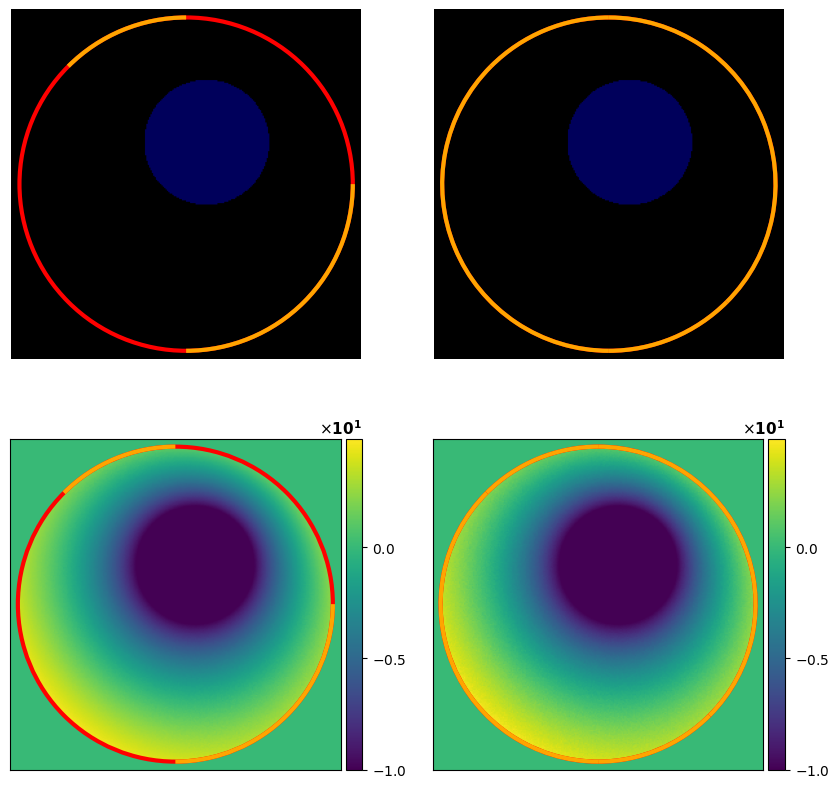

In [15]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
max_val = max(image1.max(), image2.max())
min_val = min(image1.min(), image2.min())
range_ = [min_val, max_val]
plot_image(image1, ax3, input_range=range_)
shape_holder1.sketch(ax1, bbox_, resolution_image)
plot_image(image2, ax4, input_range=range_)
shape_holder2.sketch(ax2, bbox_, resolution_image)

shape_holder1.out_boundary.sketchNeumann(ax3, bbox_, resolution_image)
shape_holder2.out_boundary.sketchNeumann(ax4, bbox_, resolution_image)

Mean:
0.0004549493
Variance:
0.0031355154


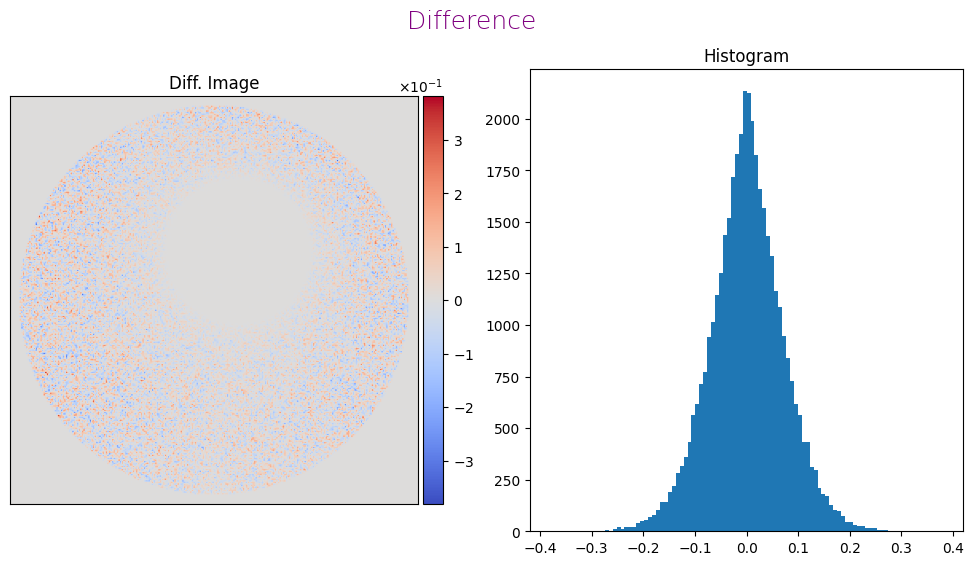

In [12]:
sketch_diff(image1, image2, max_range = 0.5)